In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

import milopy.core as milo
import milopy.plot as milopl

In [3]:
input_file = "./CTCL/objects-new/all_samples_scvi_4kbydonor_6dim_100hidd_leiden_broad_ct_mastcell_corrected_celltypist.h5ad"
adata = sc.read_h5ad(input_file)

In [4]:
adata

AnnData object with n_obs × n_vars = 885959 × 15777
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type'
    var: 'genes', 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'tech_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

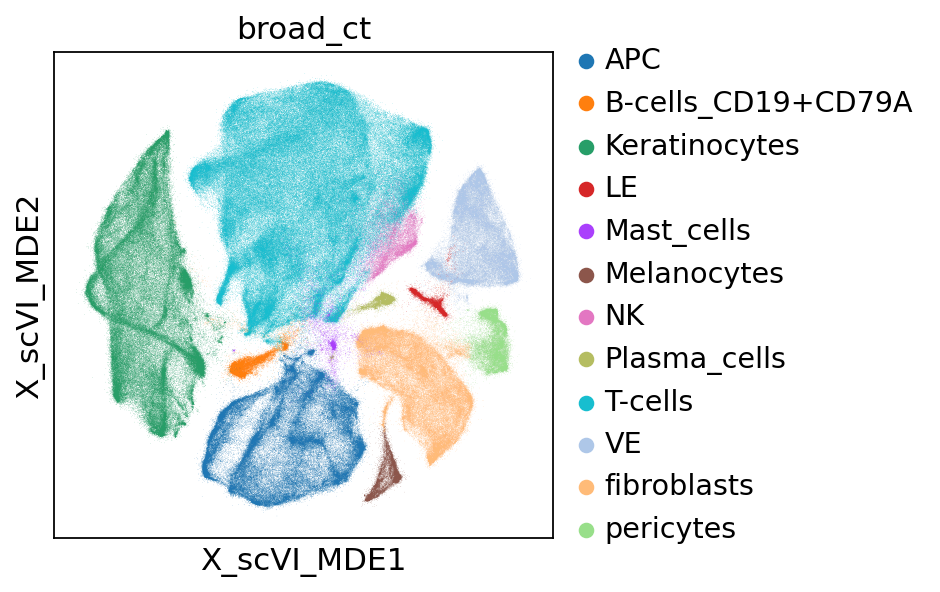

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.embedding(adata, color=['broad_ct'], basis = 'X_scVI_MDE')

In [6]:
import random
random.seed(11)

adata = sc.pp.subsample(adata, fraction=0.2, copy=True)
adata.X.shape


(177191, 15777)

In [8]:
adata.obs['sample_type'].value_counts()

CTCL            83937
healthy_skin    41501
psoriasis       26806
AD              24947
Name: sample_type, dtype: int64

In [10]:
adata

AnnData object with n_obs × n_vars = 177191 × 15777
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type'
    var: 'genes', 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'tech_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [13]:
adata.obs['Condition'] = "a_Other"
ll = adata.obs['sample_type'] == 'CTCL'
adata.obs.loc[ll, 'Condition'] = 'CTCL'


In [14]:
adata.obs['Condition'].value_counts()

a_Other    93254
CTCL       83937
Name: Condition, dtype: int64

In [15]:

## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 100, key_added="scvi") ## for subsample 0.1
#sc.pp.neighbors(adata, n_neighbors = 180, n_pcs = 50) ## harmony

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)


computing neighbors


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['scvi']`
    `.obsp['scvi_distances']`, distances for each pair of neighbors
    `.obsp['scvi_connectivities']`, weighted adjacency matrix (0:02:22)


In [ ]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]


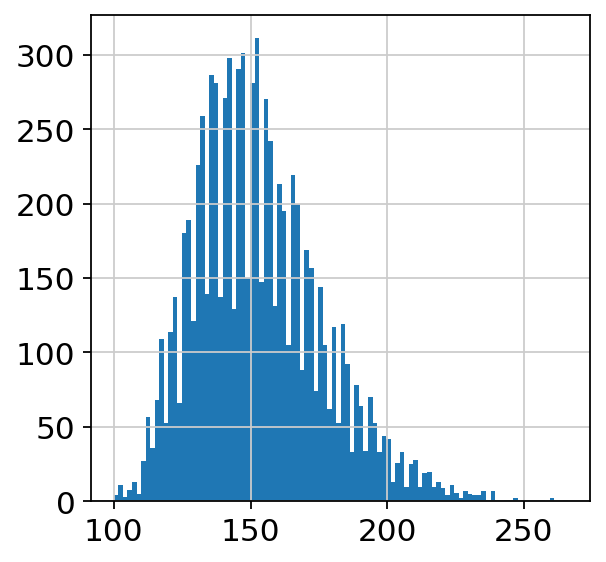

In [17]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [18]:
milo.count_nhoods(adata, sample_col="donor")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/milopy/core.py:157: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  nhood_adata = anndata.AnnData(X=nhood_count_mat, var=nhood_var)


In [19]:
adata.uns["nhood_adata"]


AnnData object with n_obs × n_vars = 8196 × 48
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [20]:
milo.DA_nhoods(adata, design="~Condition")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


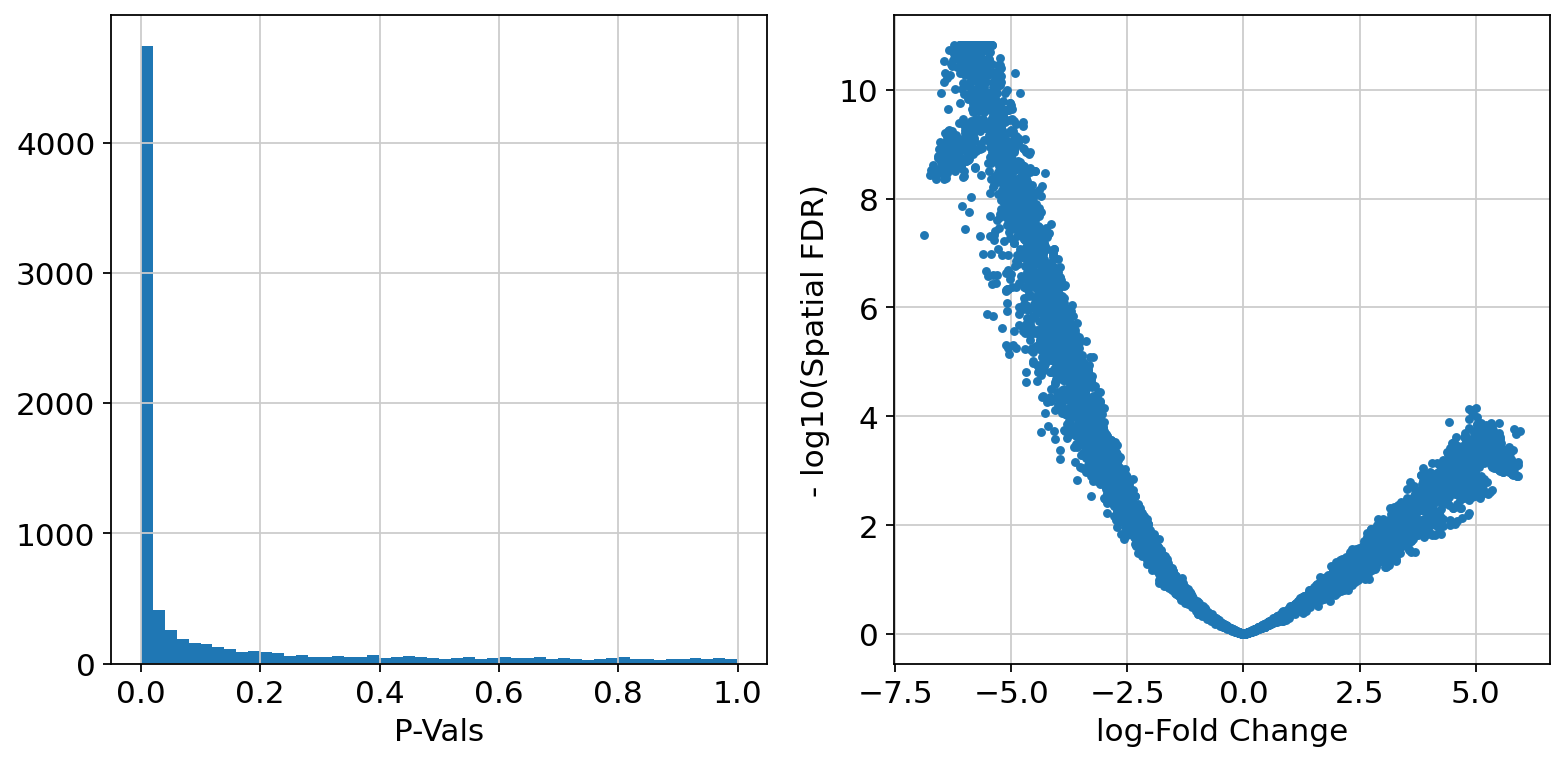

In [21]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [22]:
adata

AnnData object with n_obs × n_vars = 177191 × 15777
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type', 'Condition', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'genes', 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'tech_colors', 'scvi', 'nhood_neighbors_key', 'nhood_adata'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', 'nhoods'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances', 'scvi_distances', 'scvi_connectivities'

In [23]:
import milopy.utils
milopy.utils.build_nhood_graph(adata, basis = 'X_scVI_MDE')
#milopy.utils.build_nhood_graph(adata, basis = 'X_umap')

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


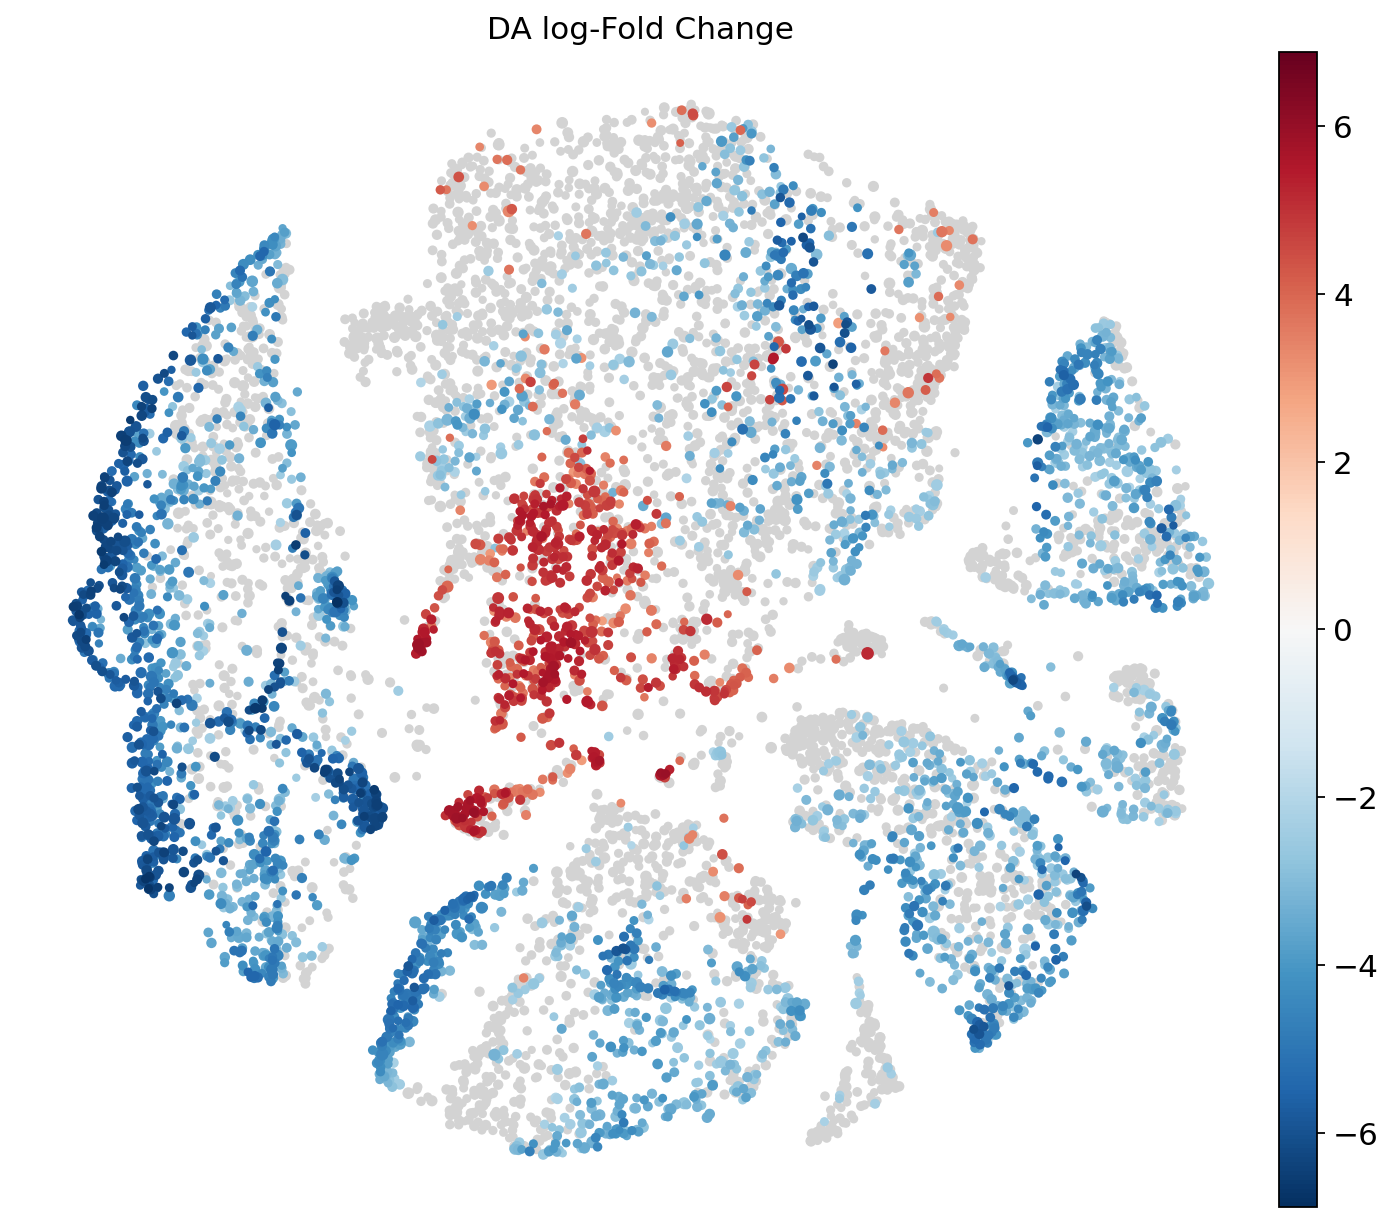

In [24]:
plt.rcParams["figure.figsize"] = [11,9.5]
milopl.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=0.5, ## Size of smallest dot\
                        plot_edges = False)

In [25]:
milopy.utils.annotate_nhoods(adata, anno_col='broad_ct')

Text(0.5, 0, 'celltype fraction')

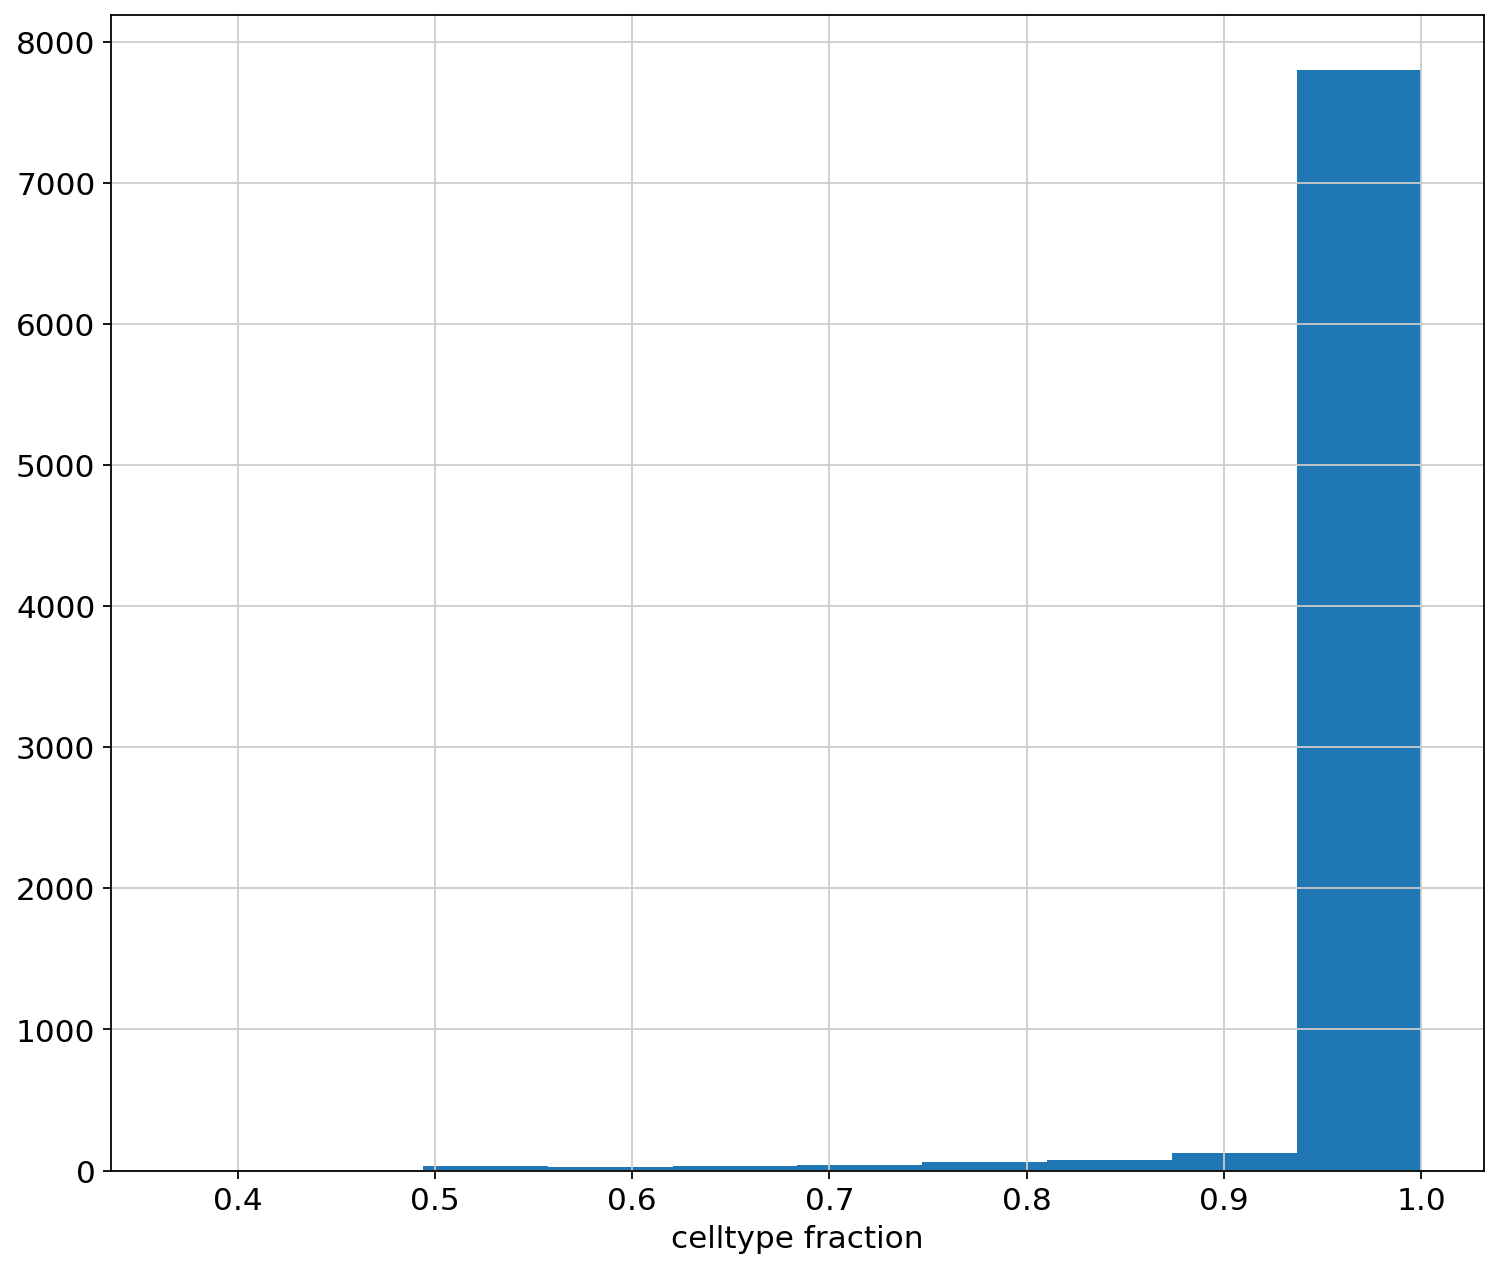

In [26]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [27]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.8, "nhood_annotation"] = "Mixed"

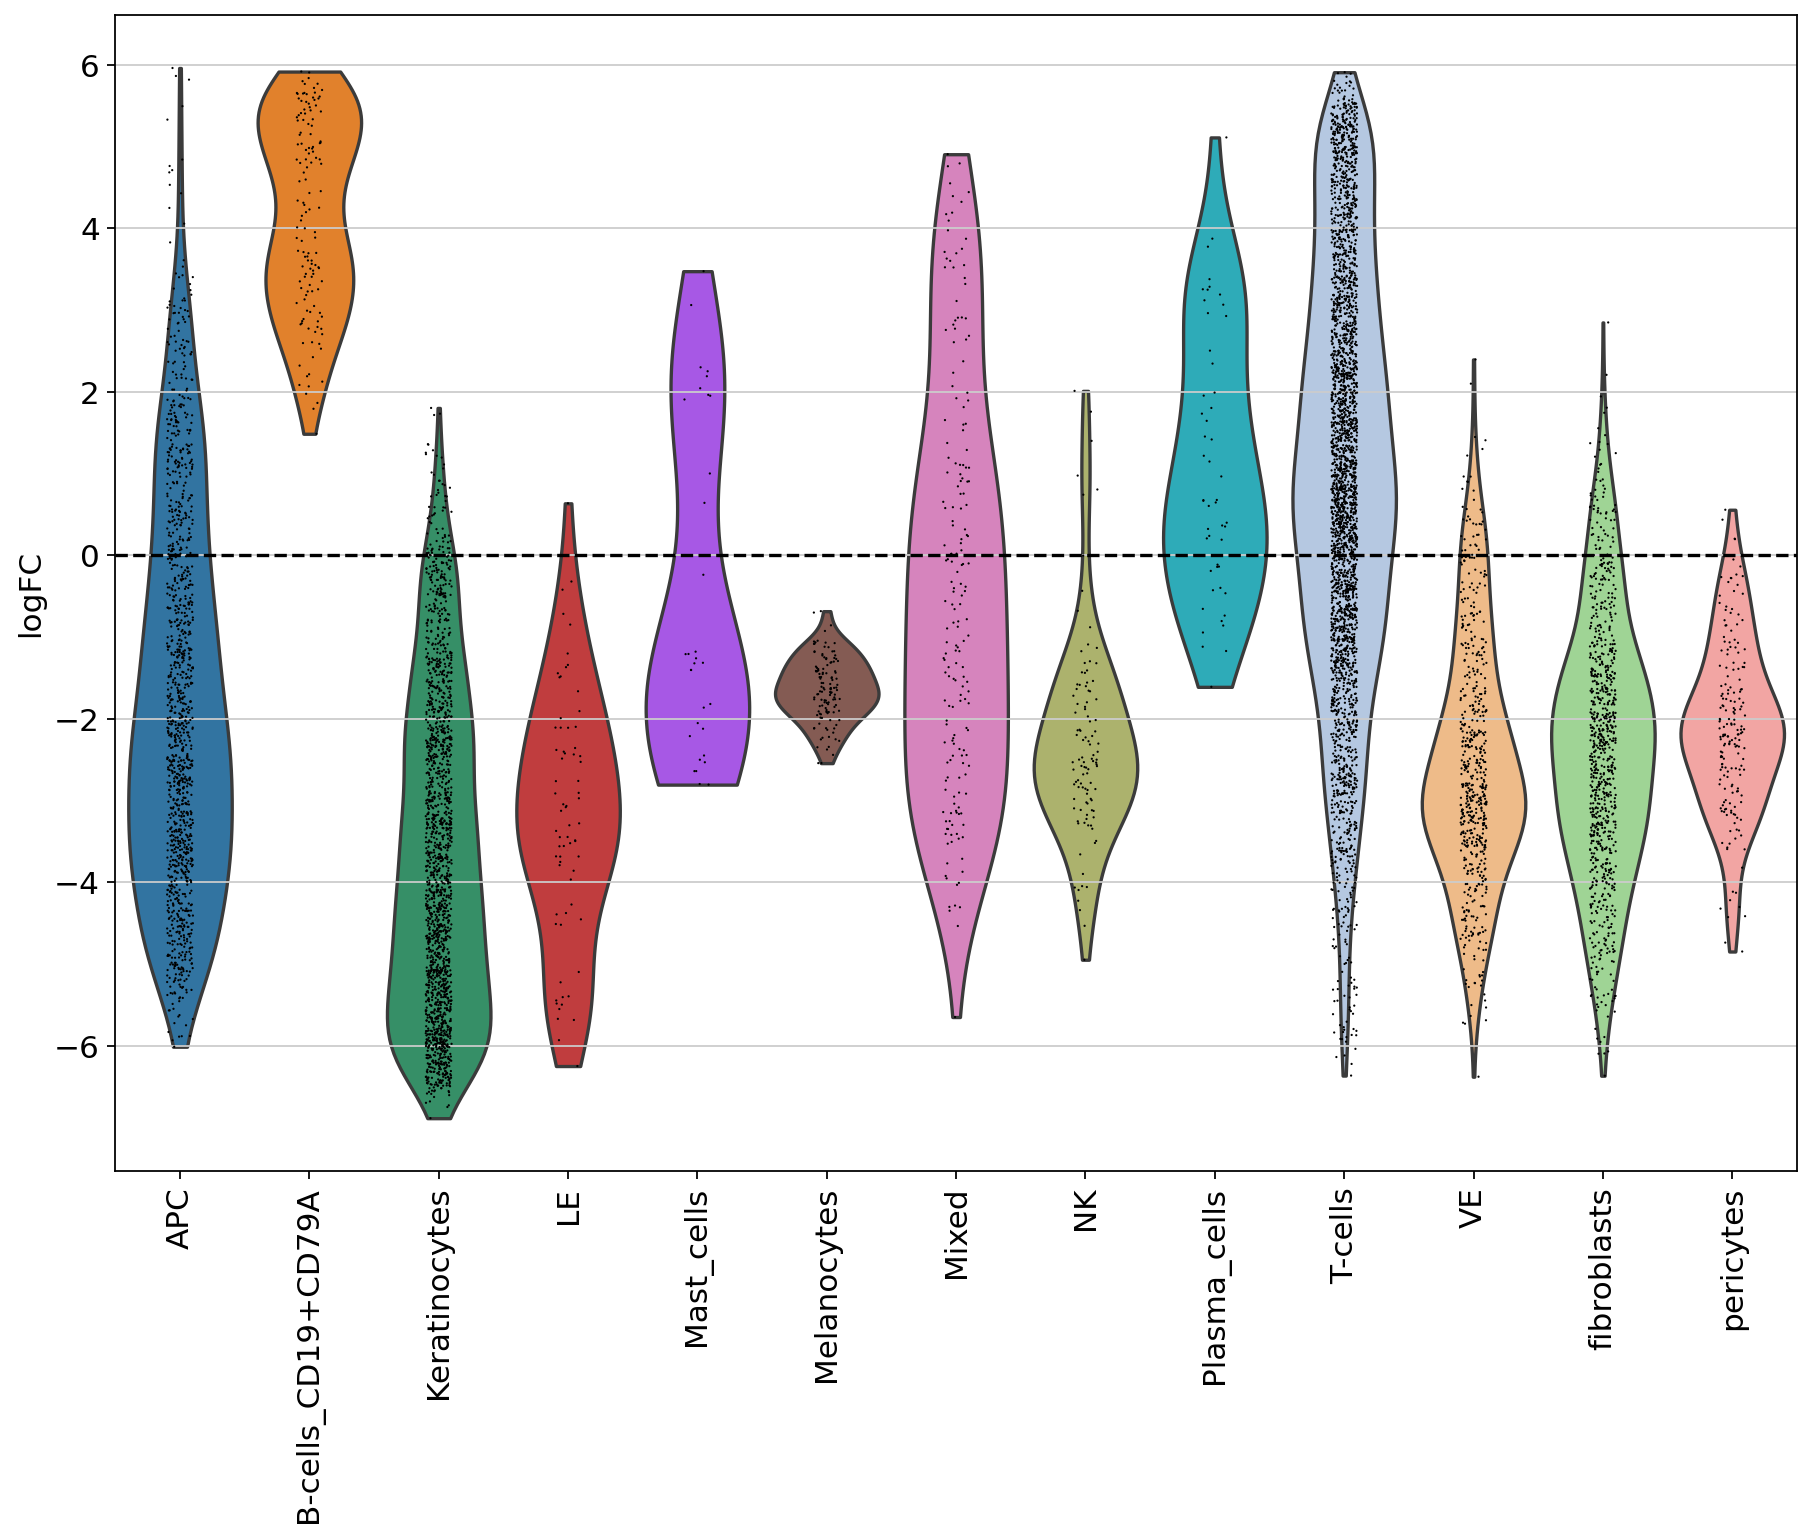

In [28]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [ ]:
adata.uns["nhood_adata"].obs

In [31]:
adata.uns["nhood_adata"].obs.to_csv('nhood_milo_overall_sub0.2.csv')

In [32]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [33]:
%load_ext rpy2.ipython

In [36]:
%%R
library(miloR)
library(igraph)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

In [37]:
%%R 
DA_results <- read.csv('nhood_milo_overall_sub0.2.csv')
DA_results$Nhood <- DA_results$Nhood+1
DA_results %>% head

  X                            index_cell kth_distance      logFC   logCPM
1 0 TTCTACATCTGCGTAA-34_CTCL3_CTCL3_CTCL3    0.4953904  2.6076134 8.991284
2 1                CCTATTAGTTATCGGT-66_P2    0.8236949 -4.9076437 8.280080
3 2 CAAGATCCAAGGTGTG-16_CTCL7_CTCL7_CTCL7    0.6054571 -1.6784576 8.660045
4 3                TGGTTAGGTAAAGGAG-87_S5    0.4325908 -0.3827576 8.469117
5 4                 ACTTACTTCAAGGTAA-2_S1    0.7288855 -2.4863227 8.307392
6 5  CGATCGGGTCTCGTTC-0_CTCL1_CTCL1_CTCL1    0.6234033 -1.0527604 8.663228
           F       PValue          FDR   SpatialFDR Nhood_size nhood_annotation
1  3.4638001 6.556376e-02 9.830966e-02 9.891025e-02        192          T-cells
2 56.8007139 1.734647e-11 4.401600e-10 4.255465e-10        116      fibroblasts
3  3.8912391 5.120574e-02 7.924514e-02 7.979454e-02        188        pericytes
4  0.1996961 6.558999e-01 7.121149e-01 7.128569e-01        145          T-cells
5 11.9046360 8.115619e-04 2.051685e-03 2.063643e-03        128             

In [38]:
%%R 
DA_results_filter <- DA_results[DA_results$SpatialFDR < 0.01,]
DA_results_filter %>% head

    X             index_cell kth_distance     logFC   logCPM        F
2   1 CCTATTAGTTATCGGT-66_P2    0.8236949 -4.907644 8.280080 56.80071
5   4  ACTTACTTCAAGGTAA-2_S1    0.7288855 -2.486323 8.307392 11.90464
7   6 TTTCCTCGTCTAGCGC-86_S5    0.5855092 -4.693348 8.230614 47.92473
9   8  GTCCTCACACGAAATA-1_S1    0.4713737 -2.572698 8.265106 11.23580
12 11 TCTGGAAGTTGCTCCT-44_E4    0.6054284 -5.346573 8.410726 53.79359
13 12 CCTTTCTAGGCCGAAT-42_E4    0.5999023 -2.510212 8.342270 10.33102
         PValue          FDR   SpatialFDR Nhood_size nhood_annotation
2  1.734647e-11 4.401600e-10 4.255465e-10        116      fibroblasts
5  8.115619e-04 2.051685e-03 2.063643e-03        128               VE
7  3.617251e-10 4.321718e-09 4.119171e-09        129    Keratinocytes
9  1.121220e-03 2.718792e-03 2.728850e-03        127            Mixed
12 4.734256e-11 9.203573e-10 8.968988e-10        143    Keratinocytes
13 1.744813e-03 4.032916e-03 4.049857e-03        128    Keratinocytes
   nhood_annotation_

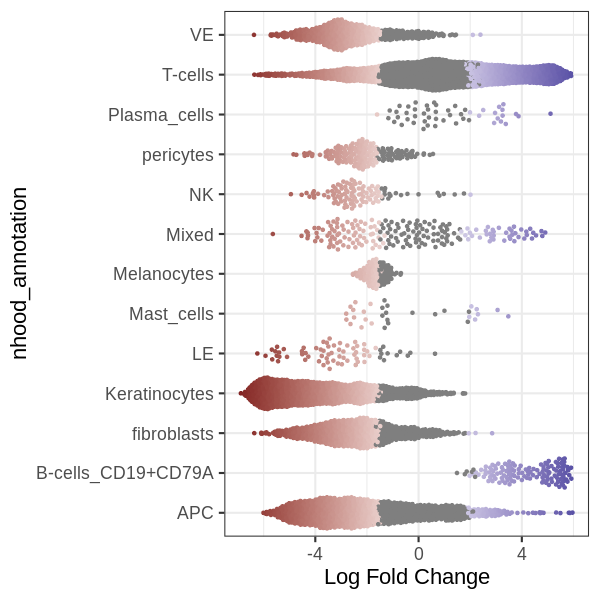

In [39]:
%%R -w 600 -h 600
plotDAbeeswarm(DA_results, group.by = "nhood_annotation")

In [40]:
%%R -w 800 -h 900 
library(ggplot2)

DA_results_filter <- DA_results[DA_results$nhood_annotation != 'Mixed', ]

plotDAbeeswarm(DA_results_filter, group.by = "nhood_annotation") + 
    theme(legend.position = "none") +
    #geom_point(size = 0.01) +
    #theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    geom_hline(yintercept=0, linetype=2, color="black")+
    scale_colour_gradient2(low = scales::muted("blue"), mid = "white",
                           high = scales::muted("red"))

ggsave("./figures/milo_all_sub0.2.pdf")
### "cell_states" represents pre-defined/pre-annotated cell clusters

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 11.1 x 12.5 in image
